In [358]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
real_type = tf.float32

In [359]:
class ForwardLayer(keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        self.w = self.add_weight(
            name = 'weights',
            shape=(input_shape[-1], self.units),
            initializer="glorot_normal",
            trainable=True
        )
        self.b = self.add_weight(
            name = 'bias',
            shape=(self.units,), 
            initializer="zeros", 
            trainable=True
        )
        super().build(input_shape)

    def call(self, inputs):
        return keras.activations.softplus(inputs) @ self.w + self.b

class BackpropLayer(keras.layers.Layer):
    def __init__(self, twin: ForwardLayer, **kwargs):
        super().__init__(**kwargs)
        self.twin = twin
        self.units = self.twin.units

    def build(self, input_shape):
        self.w = self.twin.w
        super().build(input_shape)

    def call(self, inputs, output=False):
        z, zbar = inputs
        if not output:
            return zbar @ tf.transpose(self.twin.w) * keras.activations.sigmoid(z)
        if output:
            return zbar @ tf.transpose(self.twin.w)

In [360]:
forward_1 = ForwardLayer(units=4, name='forward_1')
forward_2 = ForwardLayer(units=4, name='forward_2')
forward_3 = ForwardLayer(units=4, name='forward_3')
output = ForwardLayer(units=1, name='output')
backprop_1 = BackpropLayer(twin=output, name='backprop_1')
backprop_2 = BackpropLayer(twin=forward_3, name='backprop_2')
backprop_3 = BackpropLayer(twin=forward_2, name='backprop_3')
derivs = BackpropLayer(twin=forward_1, name='derivs')

In [361]:
z0 = keras.layers.Input(shape=(1,), name='input')
z1 = forward_1(z0)
z2 = forward_2(z1)
z3 = forward_3(z2)
y = output(z3)
zbar4 = tf.ones_like(y)
zbar3 = backprop_1(inputs=[z3,zbar4])
zbar2 = backprop_2(inputs=[z2,zbar3])
zbar1 = backprop_3(inputs=[z1,zbar2])
derivs = derivs(inputs=[1,zbar1], output=True)

In [362]:
model = keras.Model(inputs=z0, outputs=[y,derivs])
model.compile(loss=['mse','mse'], loss_weights=[0.5,0.5], optimizer=keras.optimizers.Adam(learning_rate=0.11))

In [363]:
# From Savine notebook

from scipy.stats import norm

def bsPrice(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    d2 = d1 - vol * np.sqrt(T)
    return spot * norm.cdf(d1) - strike * norm.cdf(d2)

def bsDelta(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return norm.cdf(d1)

def bsVega(spot, strike, vol, T):
    d1 = (np.log(spot/strike) + 0.5 * vol * vol * T) / vol / np.sqrt(T)
    return spot * np.sqrt(T) * norm.pdf(d1)
    
class BlackScholes:
    
    def __init__(self, 
                 vol=0.2,
                 T1=1, 
                 T2=2, 
                 K=1.10,
                 volMult=1.5):
        
        self.spot = 1
        self.vol = vol
        self.T1 = T1
        self.T2 = T2
        self.K = K
        self.volMult = volMult
                        
    def trainingSet(self, m, anti=True):
            
        returns = np.random.normal(size=[m, 2])

        vol0 = self.vol * self.volMult
        R1 = np.exp(-0.5*vol0*vol0*self.T1 + vol0*np.sqrt(self.T1)*returns[:,0])
        R2 = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    + self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
        S1 = self.spot * R1
        S2 = S1 * R2 

        pay = np.maximum(0, S2 - self.K)
        
        if anti:
            
            R2a = np.exp(-0.5*self.vol*self.vol*(self.T2-self.T1) \
                    - self.vol*np.sqrt(self.T2-self.T1)*returns[:,1])
            S2a = S1 * R2a             
            paya = np.maximum(0, S2a - self.K)
            
            X = S1
            Y = 0.5 * (pay + paya)
    
            Z1 =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
            Z2 =  np.where(S2a > self.K, R2a, 0.0).reshape((-1,1)) 
            Z = 0.5 * (Z1 + Z2)
                    
        else:
        
            X = S1
            Y = pay
            
            Z =  np.where(S2 > self.K, R2, 0.0).reshape((-1,1)) 
        
        return X.reshape([-1,1]), Y.reshape([-1,1]), Z.reshape([-1,1])
    
    def testSet(self, lower=0.35, upper=1.65, num=100):
        
        spots = np.linspace(lower, upper, num).reshape((-1, 1))
        prices = bsPrice(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        deltas = bsDelta(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        vegas = bsVega(spots, self.K, self.vol, self.T2 - self.T1).reshape((-1, 1))
        return spots, spots, prices, deltas, vegas   

In [364]:
nTest = 8192
bs = BlackScholes()
xTrain, yTrain, dydxTrain = bs.trainingSet(nTest)
xTest, xAxis, yTest, dydxTest, vegas = bs.testSet(num=nTest)

In [365]:
history = model.fit(
    xTrain, [yTrain, dydxTrain], epochs=100
)

Epoch 1/100
256/256 [==============================] - 1s 1ms/step - loss: 0.0573 - output_loss: 0.0272 - derivs_loss: 0.0874
Epoch 2/100
256/256 [==============================] - 0s 970us/step - loss: 0.0255 - output_loss: 0.0048 - derivs_loss: 0.0462
Epoch 3/100
256/256 [==============================] - 0s 922us/step - loss: 0.0249 - output_loss: 0.0045 - derivs_loss: 0.0454
Epoch 4/100
256/256 [==============================] - 0s 924us/step - loss: 0.0248 - output_loss: 0.0046 - derivs_loss: 0.0450
Epoch 5/100
256/256 [==============================] - 0s 918us/step - loss: 0.0258 - output_loss: 0.0050 - derivs_loss: 0.0467
Epoch 6/100
256/256 [==============================] - 0s 920us/step - loss: 0.0259 - output_loss: 0.0053 - derivs_loss: 0.0464
Epoch 7/100
256/256 [==============================] - 0s 928us/step - loss: 0.0260 - output_loss: 0.0064 - derivs_loss: 0.0457
Epoch 8/100
256/256 [==============================] - 0s 919us/step - loss: 0.0263 - output_loss: 0.0059 

In [366]:
total_loss, y_loss, dydx_loss = model.evaluate(
    xTest, [yTest, dydxTest]
)

256/256 [==============================] - 0s 775us/step - loss: 0.0153 - output_loss: 0.0298 - derivs_loss: 8.5479e-04


In [367]:
print(np.sqrt(total_loss),np.sqrt(y_loss),np.sqrt(dydx_loss))

0.12387343594524104 0.172726569808124 0.02923682635241666


In [368]:
y_pred, dydx_pred = model.predict(xTest)

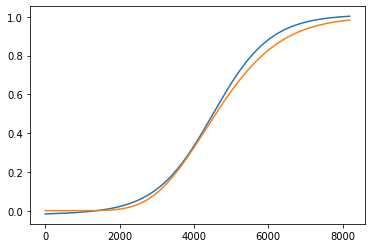

In [369]:
import matplotlib.pyplot as plt
plt.plot(dydx_pred)
plt.plot(dydxTest)